# RM for OBC data redatuming

In [21]:
# env: UD_RM
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import matplotlib.pyplot as plt

from scipy.signal import convolve, filtfilt
from scipy.sparse.linalg import lsqr
from scipy.sparse import vstack

from pylops.utils                      import dottest
from pylops.utils.wavelets             import *
from pylops.utils.seismicevents        import *
from pylops.utils.tapers               import *
from pylops.basicoperators             import *
from pylops.signalprocessing           import *
from pylops.waveeqprocessing.mdd       import *
from pylops.waveeqprocessing.marchenko import directwave
from pylops.optimization.leastsquares  import *

## Inputs

In [2]:
inputfile = '../dataset/inputdata_syncline.npz' 
inputdata = np.load(inputfile)
inputdata.files

['rho', 'vel', 'x', 'z', 't', 'wav', 's', 'r', 'Pd', 'Puw']

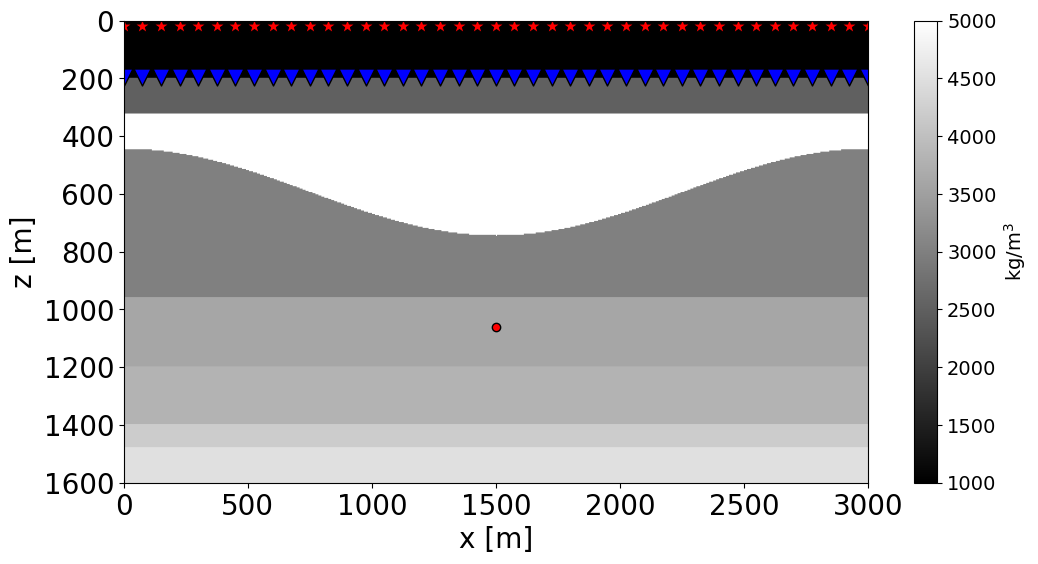

In [3]:
# Receivers
r = inputdata['r']
nr = r.shape[1]
dr = r[0,1]-r[0,0]

# Sources
s = inputdata['s']
ns = s.shape[1]
ds = s[0,1]-s[0,0]

# models
rho = inputdata['rho']
vel = inputdata['vel']
vel_dir = 2400.0         # velocity

# Time axis
t = inputdata['t']
ot, dt, nt = t[0], t[1]-t[0], len(t)

# Axes
x, z = inputdata['x'], inputdata['z']
dx, dz = x[1] - x[0], z[1] - z[0]

# Wavelet
wav = inputdata['wav']
wav = wav / np.max(np.abs(np.fft.fft(wav))*dt) 
wav_c = np.argmax(wav)

# vs=(1200,660)        #visual source
vs=(1500,1060)        #visual source

plt.figure(figsize=(12,6))
h=plt.imshow(rho, cmap='gray', extent = (x[0], x[-1], z[-1], z[0]))
plt.scatter(s[0, 0::5], s[1, 0::5], marker='*', s=150, c='r', edgecolors='k')
plt.scatter(r[0, 0::5],  r[1, 0::5], marker='v', s=150, c='b', edgecolors='k')
plt.scatter(vs[0], vs[1], c='r', edgecolors='k')
plt.axis('tight')
plt.xlabel('x [m]',fontsize=20),plt.ylabel('z [m]',fontsize=20)
# plt.title('Model and Geometry',fontsize=20)
plt.xticks(fontsize=20),plt.yticks(fontsize=20)
h1 = plt.colorbar(h)
h1.set_label('kg/m$^3$',fontsize=14)
h1.ax.tick_params(labelsize=14)
plt.xlim(x[0], x[-1]);

In [4]:
# velocity data
Pd  = inputdata['Pd'].transpose(1, 0, 2)        # organized as  (s, r, t)->(r, s, t)
Pu  = inputdata['Puw'].transpose(1, 0, 2)       # organized as  (s, r, t)->(r, s, t)

In [5]:
ntaper = 7        # source/receiver taper lenght

# tapering
taper = taper3d(nt, [nr, ns], [ntaper, ntaper], tapertype='hanning') # cosine/hanning
Pd = Pd*taper
Pu = Pu*taper

In [6]:
# Convolve data with wavelet 
convolvedata = False        # Apply convolution to data
if convolvedata:
    Pu = dt * np.apply_along_axis(convolve, -1, Pu, wav, mode='full')
    Pu = Pu[..., wav_c:][..., :nt]
    Pd = dt * np.apply_along_axis(convolve, -1, Pd, wav, mode='full')
    Pd = Pd[..., wav_c:][..., :nt] 

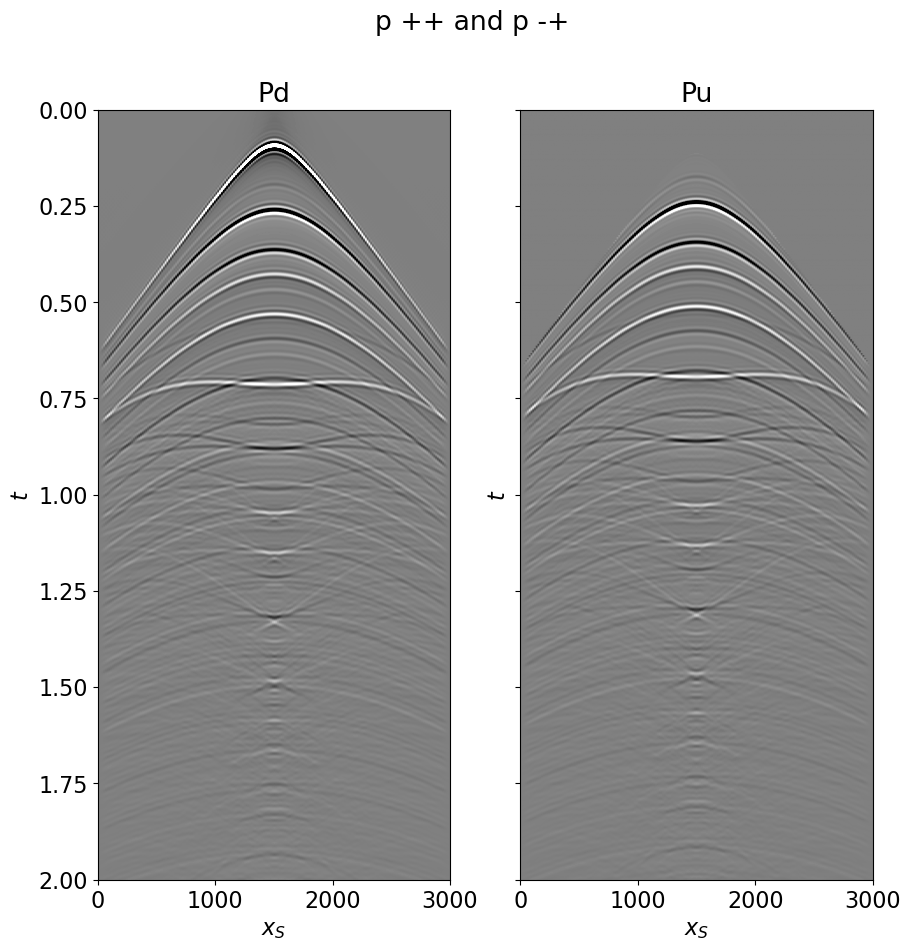

In [7]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(10, 10))
fig.suptitle('p ++ and p -+')
axs[0].imshow(Pd[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pd+Pu).max(), 
              vmax=0.1*np.abs(Pd+Pu).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[0].set_title('Pd'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(Pu[nr//2].T, cmap='gray', vmin=-0.1*np.abs(Pd+Pu).max(), 
              vmax=0.1*np.abs(Pd+Pu).max(), extent=(s[0,0], s[0,-1], t[-1], t[0]))
axs[1].set_title('Pu'), axs[1].set_xlabel(r'$x_S$'), axs[1].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(2,0);

In [8]:
# Analytical direct wave
troff = 0.04         # direct arrival time shift receiver side 
tsoff = 0.04         # direct arrival time shift source side 
nsmooth = 10         # time window smoothing 10
n_iter = 30          # iterations
nfmax = 500

# Create analytical direct wave
directVSr = np.sqrt((vs[0]-r[0])**2+(vs[1]-r[1])**2)/vel_dir # Direct arrival traveltimes vs->r
directVSs = np.sqrt((vs[0]-s[0])**2+(vs[1]-s[1])**2)/vel_dir # Direct arrival traveltimes vs->s

G0sub_ana = directwave(wav[wav_c-60:wav_c+60], directVSs, nt, dt, nfft=2**11)

# analyticaldirect wave
inputfile = '/home/wangn0e/2022-2023/first_research/dataset/input_vs_x1500_z1060.npz'
inputdata = np.load(inputfile)
dvs0 = inputdata['dvs0']
pvs02 = dvs0[:,0]
# convolve with wavelet
pvs0 = np.apply_along_axis(convolve, 0, pvs02, wav, mode='full') 
pvs01 = pvs0[wav_c:][:nt]


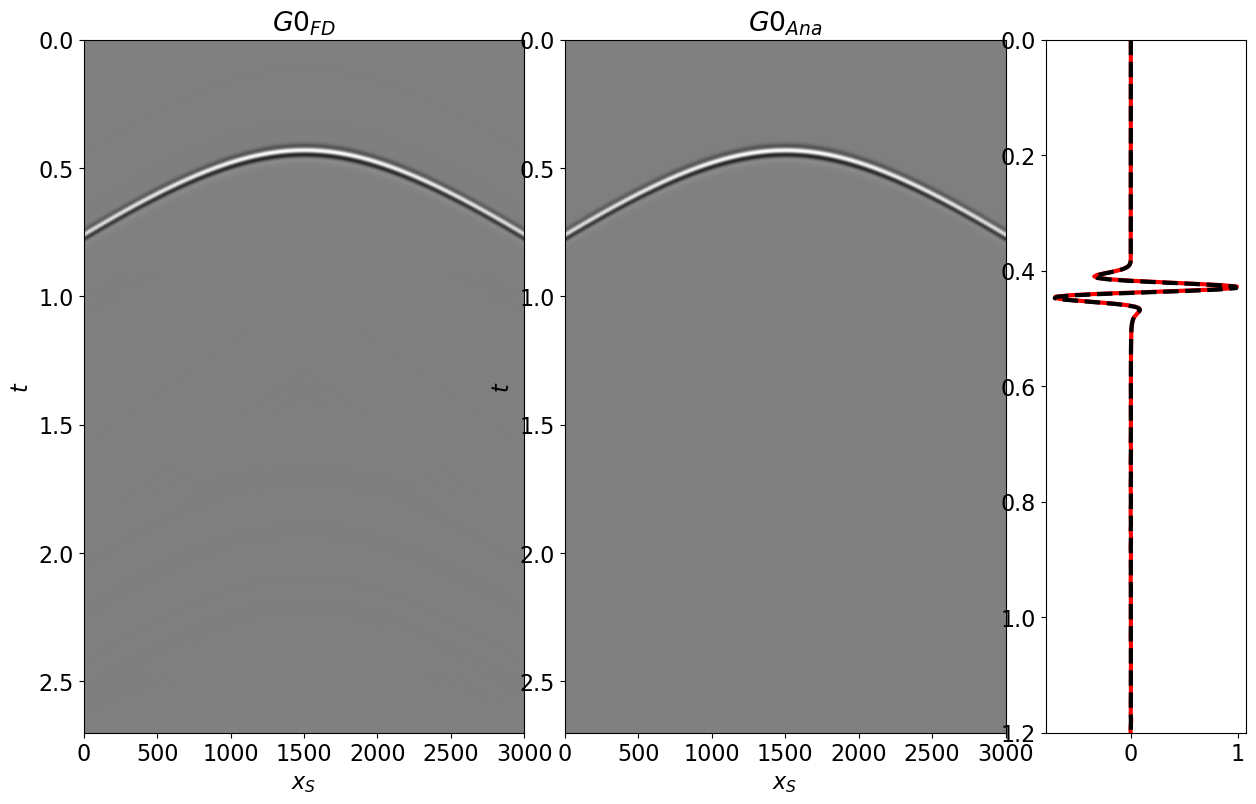

In [9]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

ax1.imshow(pvs01/pvs01.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(s[0,0], s[0,-1], t[-1], t[0]))
ax1.set_title(r'$G0_{FD}$'), ax1.set_xlabel(r'$x_S$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax2.imshow(G0sub_ana/G0sub_ana.max(), cmap='gray', vmin=-1, vmax=1, 
           extent=(s[0,0], s[0,-1], t[-1], t[0]))
ax2.set_title(r'$G0_{Ana}$'), ax2.set_xlabel(r'$x_S$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax3.plot(pvs01[:, nr//2]/pvs01.max(), t, 'r', lw=3)
ax3.plot(G0sub_ana[:, nr//2]/G0sub_ana.max(), t, '--k', lw=3)
ax3.set_ylim(1.2, 0);

In [10]:
# window VS-R
FirstVSr = np.sqrt((vs[0]-r[0])**2+(vs[1]+r[1])**2)/vel_dir
FirstVSr_off = FirstVSr - troff

iFirstVSr_off = np.round(FirstVSr_off/dt).astype(np.int32)
wr = np.zeros((nr, nt))

for ir in range(nr):
    wr[ir, :iFirstVSr_off[ir]]=1

wr = np.hstack((np.fliplr(wr), wr[:, 1:]))


In [11]:
# window VSS
FirstVSs = np.sqrt((vs[0]-s[0])**2+(vs[1]-s[1])**2)/vel_dir
FirstVSs_off = FirstVSs - tsoff

iFirstVSs_off = np.round(FirstVSs_off/dt).astype(np.int32)
ws = np.zeros((ns, nt))

for ir in range(ns):
    ws[ir, :iFirstVSs_off[ir]]=1
    
ws = np.hstack((np.fliplr(ws), ws[:, 1:]))

if nsmooth>0:
    smooth=np.ones(nsmooth)/nsmooth
    wr  = filtfilt(smooth, 1, wr)
    ws  = filtfilt(smooth, 1, ws)

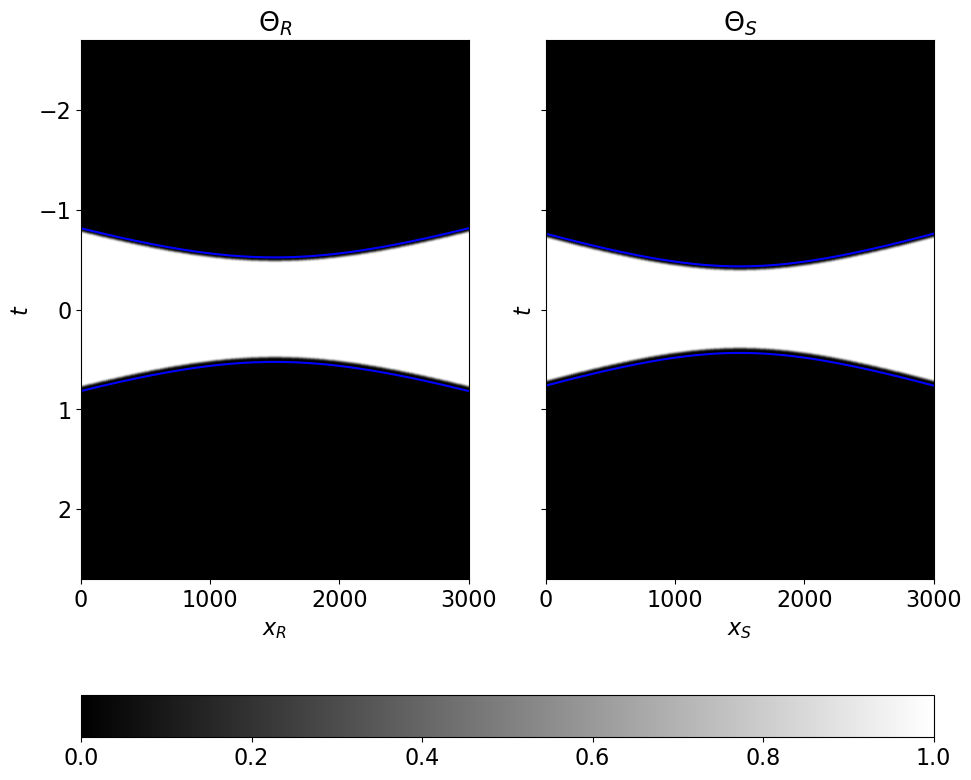

In [12]:
fig, ax = plt.subplots(1, 2,  sharey=True, figsize=(11, 10))
ax[0].imshow(wr.T, cmap='gray', extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
ax[0].plot(r[0], FirstVSr,'b'),ax[0].plot(r[0], -FirstVSr,'b')
ax[0].set_title(r'$\Theta_R$')
ax[0].set_xlabel(r'$x_R$')
ax[0].set_ylabel(r'$t$')
ax[0].axis('tight')
im=ax[1].imshow(ws.T, cmap='gray', extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
ax[1].plot(s[0], FirstVSs,'b'),ax[1].plot(s[0], -FirstVSs,'b')
ax[1].set_title(r'$\Theta_S$')
ax[1].set_xlabel(r'$x_S$')
ax[1].set_ylabel(r'$t$')
ax[1].axis('tight')

fig.colorbar(im,ax=ax[:],orientation='horizontal');

## Inversion

In [13]:
# Add negative time to Pu operators
Putwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pu), axis=-1)         # Puw[r, s, t]
Putwosided_fft = np.fft.rfft(Putwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Putwosided_fft = Putwosided_fft[...,:nfmax]
Putwosided_fft = Putwosided_fft.transpose(2, 0, 1)                           # Puw[f, r, s]

# Operators
Puop = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Puop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True) 

Pu1op = MDC(Putwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
dottest(Pu1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)   

Dot test passed, v^H(Opu)=33.00242547194685 - u^H(Op^Hv)=33.0024254719467
Dot test passed, v^H(Opu)=78.09563931987354 - u^H(Op^Hv)=78.09563931987387


True

In [14]:
# Add negative time to Pd operators
Pdtwosided = np.concatenate((np.zeros((nr, ns, nt-1)), Pd), axis=-1)         # Pd[r, s, t]
Pdtwosided_fft = np.fft.rfft(Pdtwosided, 2*nt-1, axis=-1) / np.sqrt(2*nt-1)
Pdtwosided_fft = Pdtwosided_fft[...,:nfmax]
Pdtwosided_fft = Pdtwosided_fft.transpose(2, 0, 1)                           # Pd[f, r, s]

# Operators
Pdop = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True)
dottest(Pdop, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)  

Pd1op = MDC(Pdtwosided_fft, nt=2*nt-1, nv=1, dt=dt, dr=ds, twosided=True, conj=True)
dottest(Pd1op, (2*nt-1)*nr, (2*nt-1)*ns, verb=True)    

Dot test passed, v^H(Opu)=213.2920026053934 - u^H(Op^Hv)=213.29200260539338
Dot test passed, v^H(Opu)=123.83621783384064 - u^H(Op^Hv)=123.83621783384002


True

In [15]:
# Input focusing function
fd_plus =  np.concatenate((np.flipud(G0sub_ana), np.zeros((nt-1, ns))))

Create Marchenko operator

In [16]:
Rollop = Roll((2*nt-1) * nr,
              axis=0, shift=-1)
Wxsop = Diagonal(ws.T.flatten())
Wxrop = Diagonal(wr.T.flatten())

Dop = VStack([HStack([Wxrop*Pdop, Wxrop*Puop]),
              HStack([Wxrop*Rollop*Pu1op, Wxrop*Rollop*Pd1op])])
Mop = Dop*BlockDiag([Wxsop, Wxsop])
Gop = VStack([HStack([Pdop, Puop]),
              HStack([Rollop*Pu1op, Rollop*Pd1op])])

dottest(Gop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True)
dottest(Mop, 2*nr*(2*nt-1), 2*ns*(2*nt-1), verb=True);

Dot test passed, v^H(Opu)=-212.18107614610003 - u^H(Op^Hv)=-212.18107614610028
Dot test passed, v^H(Opu)=-135.97502078294153 - u^H(Op^Hv)=-135.97502078294156


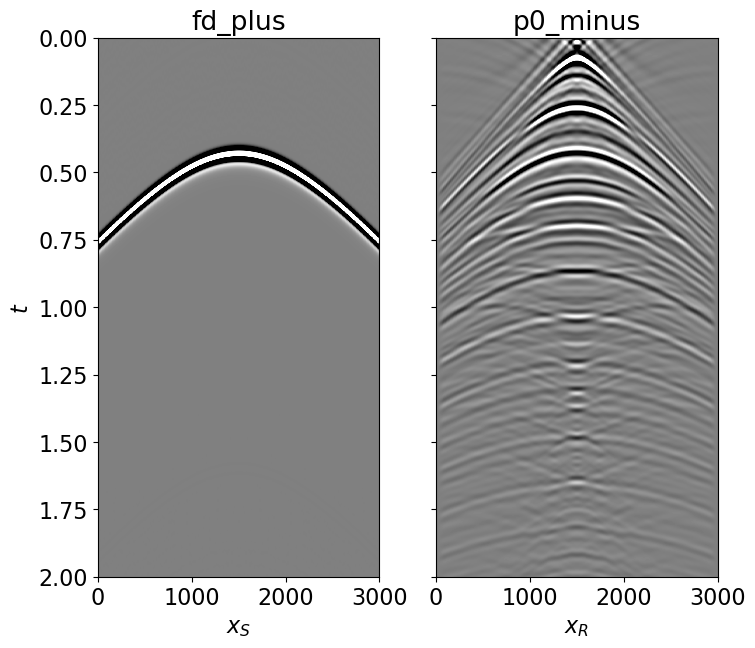

In [17]:
# Create data, adjoint and inverse focusing functions
p0_minus = Puop*fd_plus.ravel()
p0_minus = p0_minus.reshape((2*nt-1), nr).T
p0_minus_2 = np.concatenate((p0_minus, np.zeros((nr, 2*nt-1))))

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(8, 7))
axs[0].imshow(np.flipud(fd_plus), cmap='gray', vmin=-0.1*np.abs(fd_plus).max(), 
              vmax=0.1*np.abs(fd_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title('fd_plus'), axs[0].set_xlabel(r'$x_S$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0)
axs[1].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('p0_minus'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);

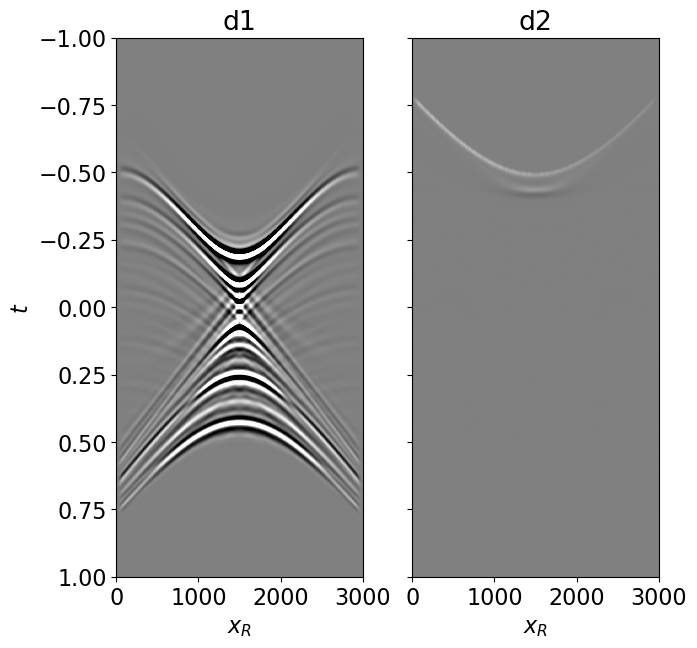

In [18]:
dinp = np.concatenate((np.zeros((2*nt-1, ns)), fd_plus), axis=0)
d = -Dop * dinp.ravel()
d = d.reshape(2*(2*nt-1), nr)

fig, axs = plt.subplots(1, 2, sharey=True, figsize=(7, 7))
axs[0].imshow(d[:(2*nt-1)], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d1'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(1, -1)
axs[1].imshow(d[(2*nt-1):], cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title('d2'), axs[1].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

In [22]:
%%time 
f1_adj = Mop.H*d.ravel()
f1_inv = lsqr(Mop, d.ravel(), iter_lim=n_iter, show=True)[0]

f1_adj = f1_adj.reshape(2*(2*nt-1), ns)
f1_inv = f1_inv.reshape(2*(2*nt-1), ns)

 
LSQR            Least-squares solution of  Ax = b
The matrix A has 868722 rows and 868722 columns
damp = 0.00000000000000e+00   calc_var =        0
atol = 1.00e-06                 conlim = 1.00e+08
btol = 1.00e-06               iter_lim =       30
 
   Itn      x[0]       r1norm     r2norm   Compatible    LS      Norm A   Cond A
     0  0.00000e+00   1.626e+03  1.626e+03    1.0e+00  4.9e-04
     1  0.00000e+00   1.077e+03  1.077e+03    6.6e-01  6.5e-01   1.1e+00  1.0e+00
     2  0.00000e+00   6.118e+02  6.118e+02    3.8e-01  4.2e-01   1.5e+00  2.5e+00
     3  0.00000e+00   4.449e+02  4.449e+02    2.7e-01  4.3e-01   1.8e+00  3.8e+00
     4  0.00000e+00   3.269e+02  3.269e+02    2.0e-01  2.9e-01   2.3e+00  5.6e+00
     5  0.00000e+00   2.765e+02  2.765e+02    1.7e-01  1.5e-01   2.7e+00  7.2e+00
     6  0.00000e+00   2.384e+02  2.384e+02    1.5e-01  1.6e-01   2.9e+00  8.9e+00
     7  0.00000e+00   2.083e+02  2.083e+02    1.3e-01  1.4e-01   3.1e+00  1.1e+01
     8  0.00000e+00   1.853e+0

Add initial guess to estimated focusing functions

In [23]:
f1_adj_tot = f1_adj + np.concatenate((np.zeros((2*nt-1, ns)),
                                      np.concatenate((np.fliplr(G0sub_ana.T).T, 
                                                      np.zeros((nt-1, ns))), axis=0)))
f1_inv_tot = f1_inv + np.concatenate((np.zeros((2*nt-1, ns)),
                                      fd_plus))

Estimate Green's functions

In [24]:
g_adj = Gop*f1_adj_tot.flatten()
g_inv = Gop*f1_inv_tot.flatten()

g_adj = g_adj.reshape(2*(2*nt-1), nr)
g_inv = g_inv.reshape(2*(2*nt-1), nr)

Extract up and down focusing and Green's functions from model vectors

In [25]:
f1_adj_minus, f1_adj_plus =  f1_adj_tot[:(2*nt-1)].T, f1_adj_tot[(2*nt-1):].T
f1_inv_minus, f1_inv_plus =  f1_inv_tot[:(2*nt-1)].T, f1_inv_tot[(2*nt-1):].T

g_adj_minus, g_adj_plus =  -g_adj[:(2*nt-1)].T, np.fliplr(g_adj[(2*nt-1):].T)
g_inv_minus, g_inv_plus =  -g_inv[:(2*nt-1)].T, np.fliplr(g_inv[(2*nt-1):].T)

g_inv_tot = g_inv_minus + g_inv_plus

Visualization

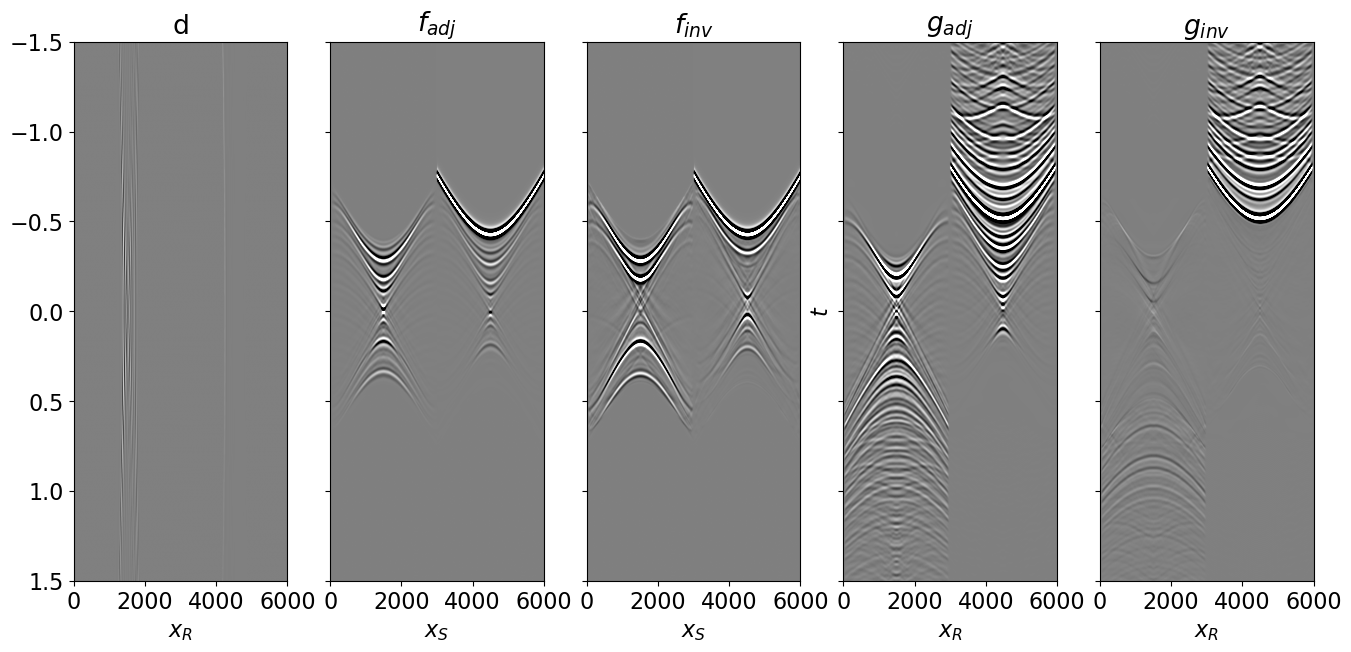

In [26]:
f1_adj_tot = np.concatenate((f1_adj_tot[:(2*nt-1)], f1_adj_tot[(2*nt-1):]), axis=1).T
f1_inv_tot = np.concatenate((f1_inv_tot[:(2*nt-1)], f1_inv_tot[(2*nt-1):]), axis=1).T
g_adj = np.concatenate((g_adj[:(2*nt-1)], g_adj[(2*nt-1):]), axis=1).T
g_inv = np.concatenate((g_inv[:(2*nt-1)], g_inv[(2*nt-1):]), axis=1).T

fig, axs = plt.subplots(1, 5, sharey=True, figsize=(16, 7))
axs[0].imshow(d.T, cmap='gray', vmin=-0.1*np.abs(d).max(), 
              vmax=0.1*np.abs(d).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[0].set_title('d'), axs[0].set_xlabel(r'$x_R$'), axs[3].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[1].imshow(f1_adj_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_adj_tot).max(), 
              vmax=0.1*np.abs(f1_adj_tot).max(), extent=(s[0,0], 2*s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f_{adj}$'), axs[1].set_xlabel(r'$x_S$')
axs[1].axis('tight')
axs[2].imshow(f1_inv_tot.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_tot).max(), 
              vmax=0.1*np.abs(f1_inv_tot).max(), extent=(s[0,0], 2*s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f_{inv}$'), axs[2].set_xlabel(r'$x_S$')
axs[2].axis('tight')
axs[3].imshow(g_adj.T, cmap='gray', vmin=-0.1*np.abs(g_adj).max(), 
              vmax=0.1*np.abs(g_adj).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[3].set_title(r'$g_{adj}$'), axs[3].set_xlabel(r'$x_R$')
axs[3].axis('tight')
axs[4].imshow(g_inv.T, cmap='gray', vmin=-0.1*np.abs(g_inv).max(), 
              vmax=0.1*np.abs(g_inv).max(), extent=(r[0,0], 2*r[0,-1], t[-1], -t[-1]))
axs[4].set_title(r'$g_{inv}$'), axs[4].set_xlabel(r'$x_R$')
axs[4].axis('tight')
axs[4].set_ylim(1.5, -1.5);

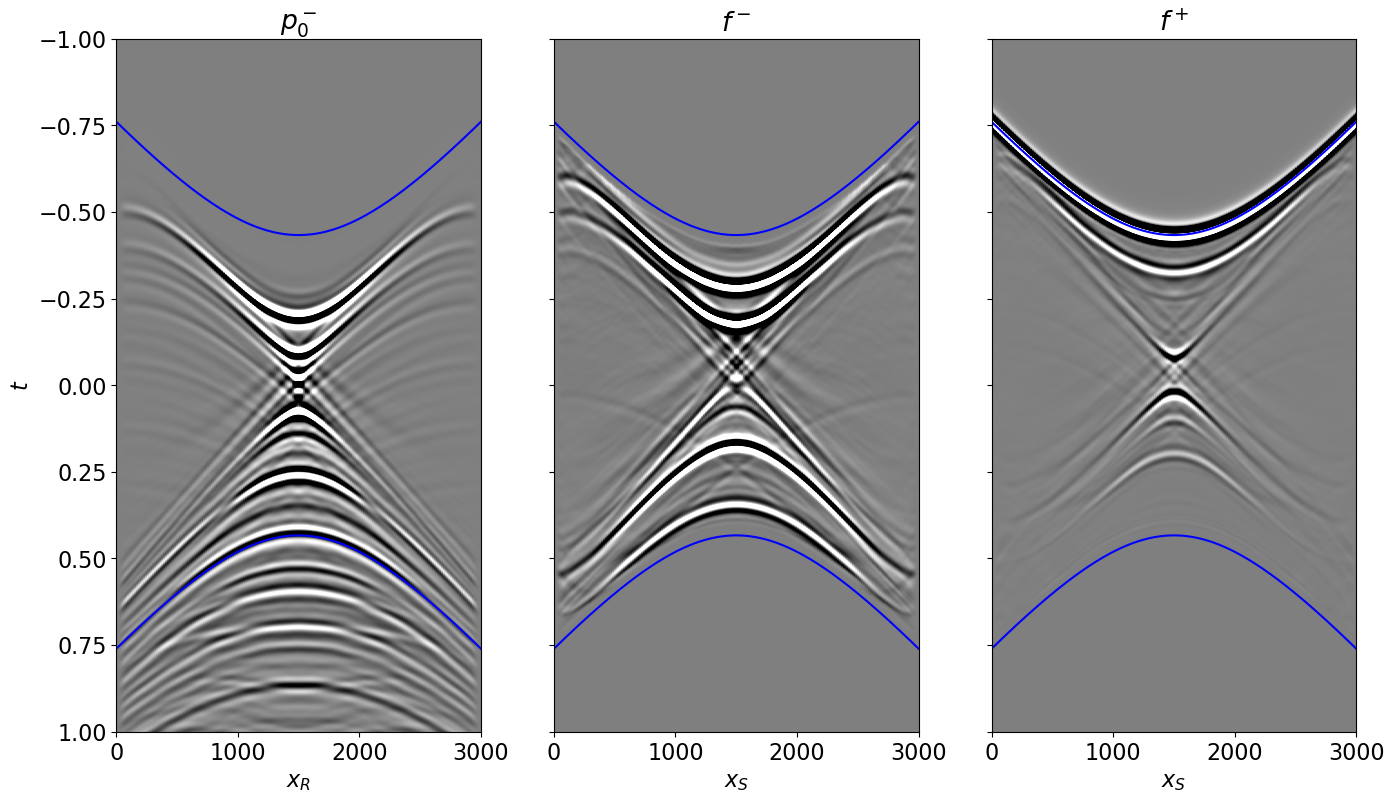

In [27]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].plot(s[0], directVSs,'b'),axs[0].plot(s[0], -directVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^-$'), axs[1].set_xlabel(r'$x_S$')
axs[1].plot(s[0], directVSs,'b'),axs[1].plot(s[0], -directVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$f^+$'), axs[2].set_xlabel(r'$x_S$')
axs[2].plot(s[0], directVSs,'b'),axs[2].plot(s[0], -directVSs,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

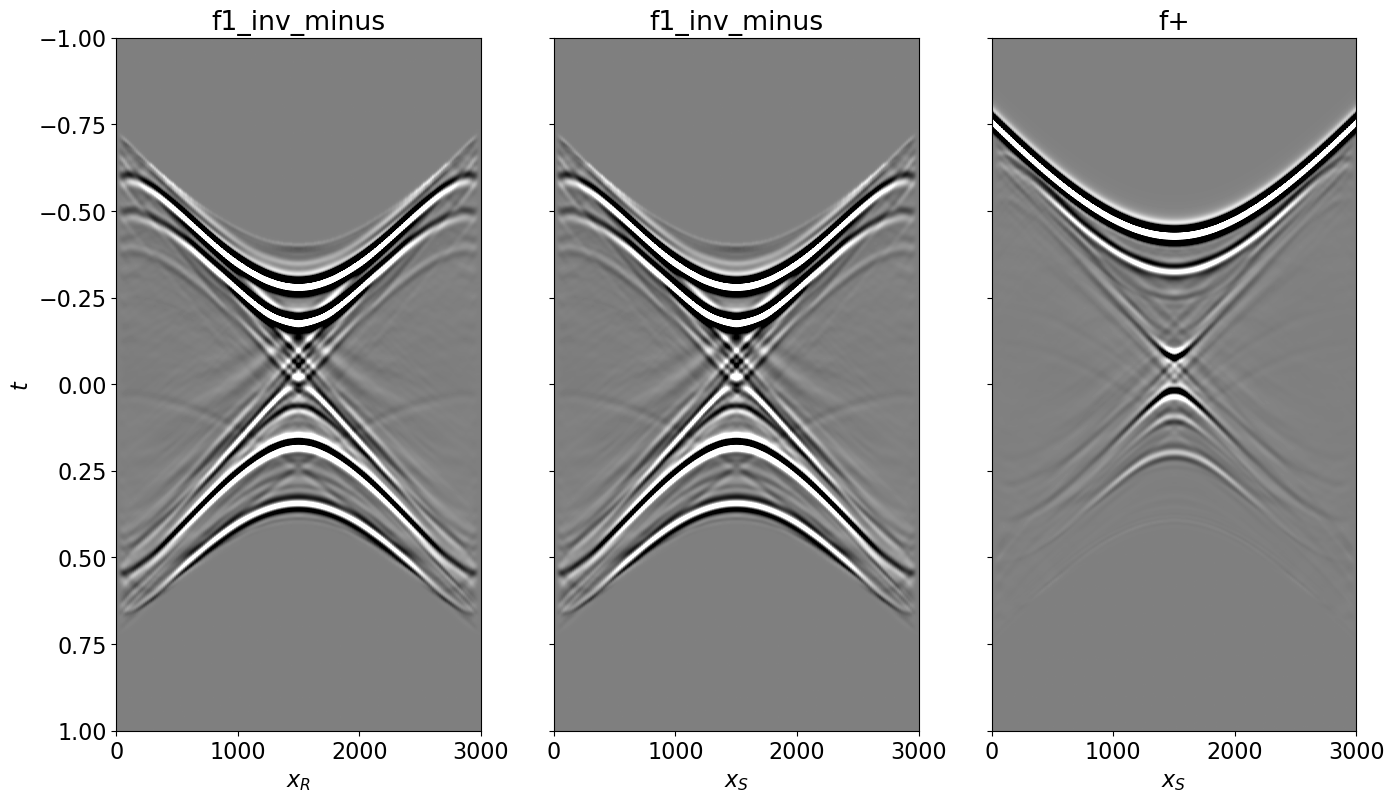

In [28]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title('f1_inv_minus'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
# axs[0].plot(s[0], directVSs,'b'),axs[0].plot(s[0], -directVSs,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title('f1_inv_minus'), axs[1].set_xlabel(r'$x_S$')
# axs[1].plot(s[0], directVSs,'b'),axs[1].plot(s[0], -directVSs,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);
axs[2].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title('f+'), axs[2].set_xlabel(r'$x_S$')
# axs[2].plot(s[0], directVSs,'b'),axs[2].plot(s[0], -directVSs,'b')
axs[2].axis('tight')
axs[2].set_ylim(1, -1);

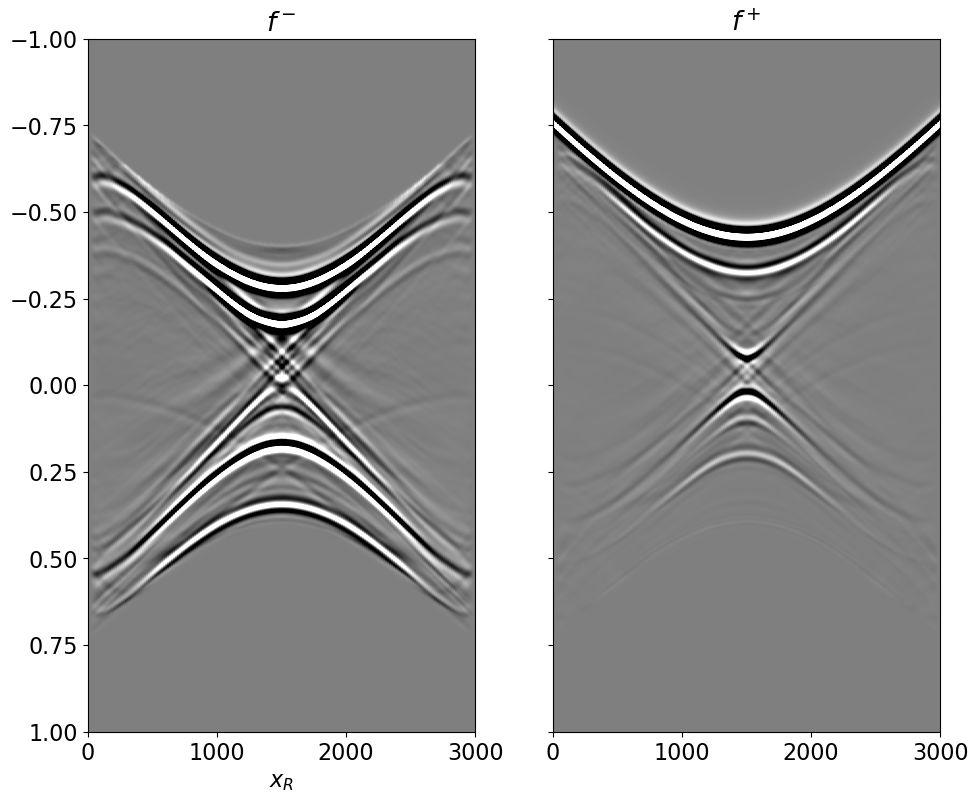

In [29]:
fig, axs = plt.subplots(1, 2, sharey=True, figsize=(11, 9))
axs[0].imshow(f1_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_minus).max(), 
              vmax=0.1*np.abs(f1_inv_minus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$f^-$'), axs[0].set_xlabel(r'$x_R$')
# axs[0].plot(r[0], directVS,'b'),axs[0].plot(r[0], -directVS,'b')
axs[0].axis('tight')
axs[0].set_ylim(1, -1);
axs[1].imshow(f1_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(f1_inv_plus).max(), 
              vmax=0.1*np.abs(f1_inv_plus).max(), extent=(r[0,0], r[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$f^+$'), axs[0].set_xlabel(r'$x_R$')
# axs[1].plot(r[0], directVS,'b'),axs[1].plot(r[0], -directVS,'b')
axs[1].axis('tight')
axs[1].set_ylim(1, -1);

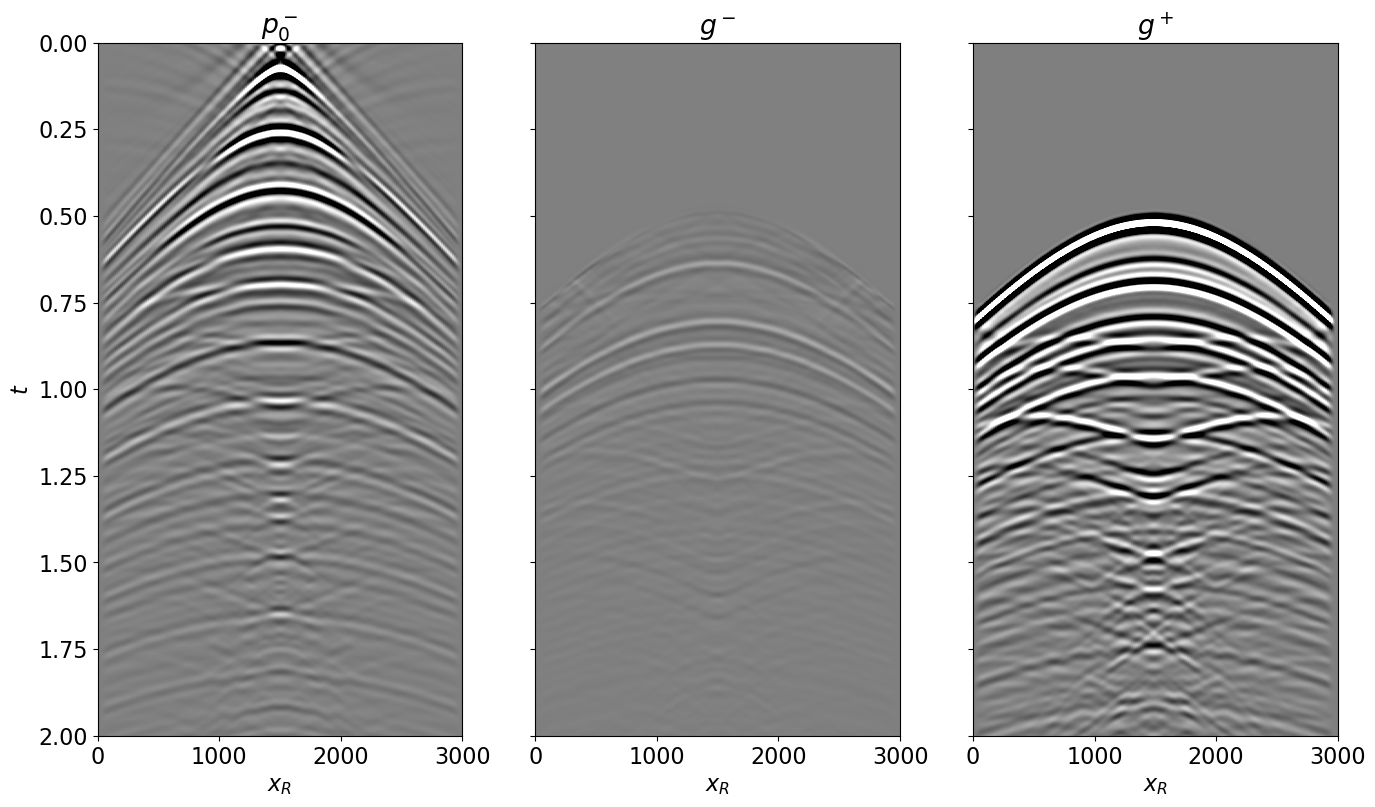

In [30]:
fig, axs = plt.subplots(1, 3, sharey=True, figsize=(16, 9))
axs[0].imshow(p0_minus.T, cmap='gray', vmin=-0.1*np.abs(p0_minus).max(), 
              vmax=0.1*np.abs(p0_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[0].set_title(r'$p_0^-$'), axs[0].set_xlabel(r'$x_R$'), axs[0].set_ylabel(r'$t$')
axs[0].axis('tight')
axs[0].set_ylim(2, 0);
axs[1].imshow((1-wr.T) * g_inv_minus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax= 0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[1].set_title(r'$g^-$'), axs[1].set_xlabel(r'$x_R$')
axs[1].axis('tight')
axs[1].set_ylim(2, 0);
axs[2].imshow((1-wr.T) * g_inv_plus.T, cmap='gray', vmin=-0.1*np.abs(g_inv_plus+g_inv_minus).max(), 
              vmax=0.1*np.abs(g_inv_plus+g_inv_minus).max(), extent=(s[0,0], s[0,-1], t[-1], -t[-1]))
axs[2].set_title(r'$g^+$'), axs[2].set_xlabel(r'$x_R$')
axs[2].axis('tight')
axs[2].set_ylim(2, 0);

In [31]:
inputfile = '/home/wangn0e/2022-2023/first_research/dataset/truegreenf_vs_x1500_z1060.npy' 
g_true = np.load(inputfile)

In [32]:
g_true = dt * np.apply_along_axis(convolve, -1, g_true, wav, mode='full')
g_true = g_true[..., wav_c:][..., :nt]

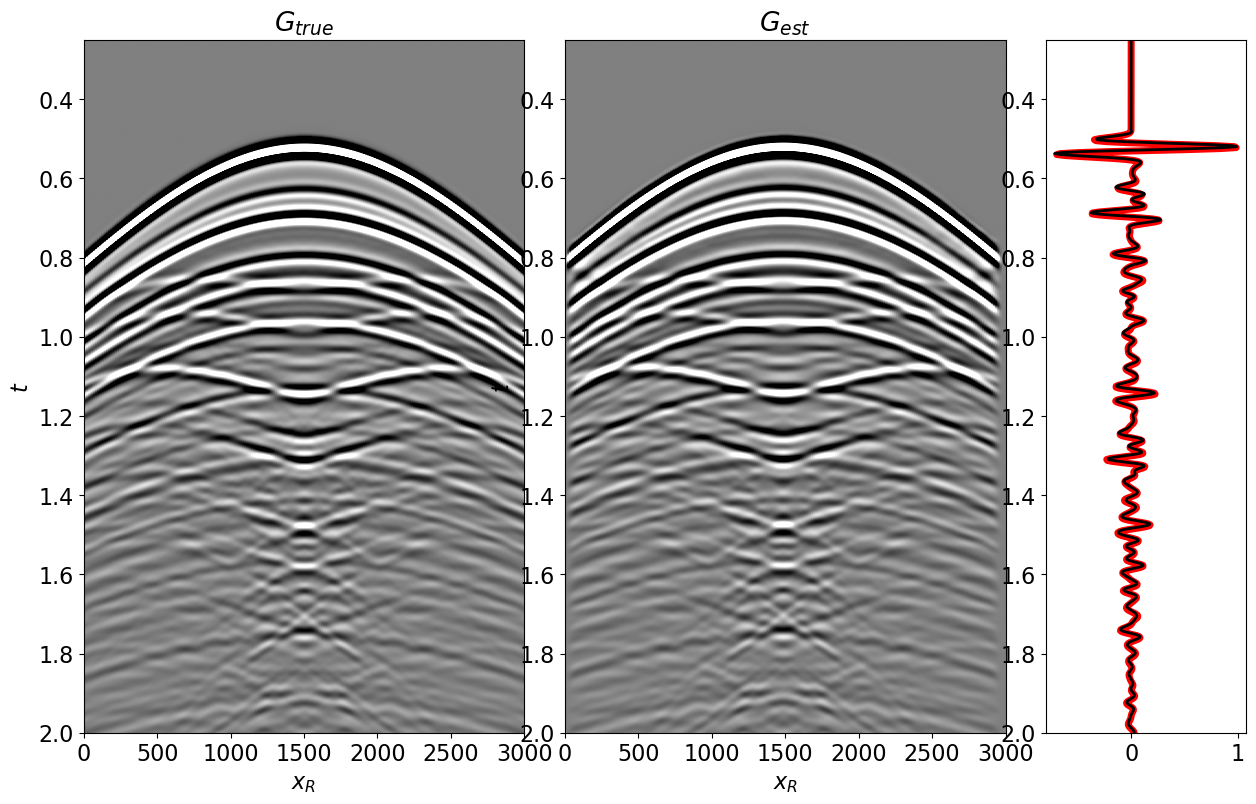

In [33]:
fig = plt.figure(figsize=(15,9))
ax1 = plt.subplot2grid((1, 5), (0, 0), colspan=2)
ax2 = plt.subplot2grid((1, 5), (0, 2), colspan=2)
ax3 = plt.subplot2grid((1, 5), (0, 4))

g_true = -(1-wr[:, nt-1:]) *g_true/g_true.max()
g_inv_tot_norm = (1-wr[:, nt-1:]) * (g_inv_tot[:, nt-1:])/(g_inv_tot).max()

ax1.imshow(g_true.T, cmap='gray', vmin=-0.1*np.abs(g_true).max(), 
           vmax=0.1*np.abs(g_true).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax1.set_title(r'$G_{true}$'), ax1.set_xlabel(r'$x_R$'), ax1.set_ylabel(r'$t$')
ax1.axis('tight')
ax1.set_ylim(2, 0.25)
ax2.imshow(g_inv_tot_norm.T, cmap='gray', vmin=-0.1*np.abs(g_inv_tot_norm).max(), 
           vmax=0.1*np.abs(g_inv_tot_norm).max(), extent=(r[0,0], r[0,-1], t[-1], t[0]))
ax2.set_title(r'$G_{est}$'), ax2.set_xlabel(r'$x_R$'), ax2.set_ylabel(r'$t$')
ax2.axis('tight')
ax2.set_ylim(2, 0.25)

ax3.plot((g_true[ns//2,:])/(g_true).max(), t, 'r', lw=5)
ax3.plot((g_inv_tot_norm[ns//2, :])/(g_inv_tot_norm).max(), t, 'k', lw=2)
ax3.set_ylim(2, 0.25);